<a href="https://colab.research.google.com/github/JosiahBegley720/FYP/blob/main/FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Defines the UNET model with modifications that will be used to predict the noise in the reverse diffusion process

In [2]:
!pip install labml_helpers
!pip install labml_nn
!pip install Pillow

import math
from typing import Optional, Tuple, Union, List

import numpy as np
import torch
from torch import nn
import torch.utils.data
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import labml
from labml import lab, tracker, experiment, monit
from labml.configs import BaseConfigs, option
from labml_helpers.device import DeviceConfigs
from labml_helpers.module import Module
from labml_nn.diffusion.ddpm import DenoiseDiffusion
from labml_nn.diffusion.ddpm.unet import UNet

from google.colab import drive
drive.mount('/content/drive')

import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
class Swish(Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

In [4]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        self.lin1 = nn.Linear(self.n_channels // 2, self.n_channels)
        self.act = nn.ReLU()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels // 2)

    def forward(self, t: torch.Tensor):
        embedding_dim = self.n_channels // 2
        time_scale = torch.exp(torch.linspace(-5, 4, embedding_dim, device=t.device))
        embedding = t[:, None] * time_scale[None, :]
        embedding = torch.cat((torch.sin(embedding), torch.cos(embedding)), dim=1)
        embedding = self.lin1(embedding)
        embedding = self.act(embedding)
        embedding = self.lin2(embedding)
        return embedding

In [5]:
class ResidualBlock(Module):

  def __init__(self, input_channels: int, output_channels: int, time_channels: int, num_groups: int = 32, drop_prob: float = 0.1):
    super().__init__()
    self.group_norm1 = nn.GroupNorm(num_groups, input_channels)
    self.swish1 = Swish()
    self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=(3, 3), padding=(1, 1))
    self.group_norm2 = nn.GroupNorm(num_groups, output_channels)
    self.swish2 = Swish()
    self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=(3, 3), padding=(1, 1))
    if input_channels != output_channels:
      self.shortcut_conv = nn.Conv2d(input_channels, output_channels, kernel_size=(1, 1))
    else:
      self.shortcut_conv = nn.Identity()
    self.time_embedding = nn.Linear(time_channels, output_channels)
    self.time_swish = Swish()
    self.dropout = nn.Dropout(drop_prob)

  def forward(self, x: torch.Tensor, t: torch.Tensor):
    h = self.conv1(self.swish1(self.group_norm1(x)))
    h += self.time_embedding(self.time_swish(t))[:, :, None, None]
    h = self.conv2(self.dropout(self.swish2(self.group_norm2(h))))
    return h + self.shortcut_conv(x)

In [6]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels: int, num_heads: int = 1, key_dim: int = None, num_groups: int = 32):
        super().__init__()
        if key_dim is None:
            key_dim = in_channels
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.norm = nn.GroupNorm(num_groups, in_channels)
        self.query = nn.Linear(in_channels, num_heads * key_dim)
        self.key = nn.Linear(in_channels, num_heads * key_dim)
        self.value = nn.Linear(in_channels, num_heads * key_dim)
        self.output = nn.Linear(num_heads * key_dim, in_channels)
        self.scale_factor = 1.0 / math.sqrt(key_dim)

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        batch_size, channels, height, width = x.shape

        # Reshape input for batched matrix multiplication
        x = x.view(batch_size, channels, -1)

        # Compute query, key, and value
        q = self.query(x).view(batch_size, -1, self.num_heads, self.key_dim)
        k = self.key(x).view(batch_size, -1, self.num_heads, self.key_dim)
        v = self.value(x).view(batch_size, -1, self.num_heads, self.key_dim)

        # Compute scaled dot-product attention
        attn_scores = torch.einsum('bqnh,bknh->bqkh', q, k) * self.scale_factor
        attn_probs = attn_scores.softmax(dim=-1)
        attn_output = torch.einsum('bqkh,bvnh->bqnv', attn_probs, v)

        # Reshape and apply output linear layer
        attn_output = attn_output.view(batch_size, -1, self.num_heads * self.key_dim)
        output = self.output(attn_output)

        # Apply residual connection and normalization
        output += x
        output = output.view(batch_size, channels, height, width)
        output = self.norm(output)

        return output


In [7]:
class DownBlock(Module):
  def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
    super().__init__()
    # Define residual block with specified input and output channels
    self.res = ResidualBlock(in_channels, out_channels, time_channels)
    # Add attention block if specified
    if has_attn:
      self.attn = AttentionBlock(out_channels)
    else:
      self.attn = nn.Identity()

  def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    # Pass input through residual block and attention block (if any)
    x = self.res(x, t)
    x = self.attn(x)
    return x

In [8]:
class UpBlock(Module):
  def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
    super().__init__()
    # Define residual block with specified input and output channels
    self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
    # Add attention block if specified
    if has_attn:
      self.attn = AttentionBlock(out_channels)
    else:
      self.attn = nn.Identity()

  def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    # Concatenate input and output channels and pass through residual block and attention block (if any)
    x = self.res(torch.cat([x, skip], dim=1), t)
    x = self.attn(x)
    return x

In [9]:
class MiddleBlock(Module):
  def __init__(self, n_channels: int, time_channels: int):
    super().__init__()
    # Define two residual blocks and an attention block
    self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
    self.attn = AttentionBlock(n_channels)
    self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

  def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    # Pass input through first residual block, attention block, and second residual block
    x = self.res1(x, t)
    x = self.attn(x)
    x = self.res2(x, t)
    return x

In [10]:
class Upsample(nn.Module):
  def __init__(self, n_channels):
    super().__init__()
    self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

  def forward(self, x: torch.Tensor, t: torch.Tensor):
    _ = t
    return self.conv(x)

In [11]:
class Downsample(nn.Module):

  def __init__(self, n_channels):
    super().__init__()
    self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

  def forward(self, x: torch.Tensor, t: torch.Tensor):
    _ = t
    return self.conv(x)

In [12]:
class UNet(Module):
    def __init__(self, image_channels=1, n_channels=64, ch_mults=(1, 2, 2, 4), is_attn=(False, False, True, True), n_blocks=2):
        super().__init__()
        n_resolutions = len(ch_mults)
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))
        self.time_emb = TimeEmbedding(n_channels * 4)
        down = []
        out_channels = in_channels = n_channels

        for i in range(n_resolutions):
            out_channels = in_channels * ch_mults[i]
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels

            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        self.down = nn.ModuleList(down)
        self.middle = MiddleBlock(out_channels, n_channels * 4)
        up = []
        in_channels = out_channels

        for i in reversed(range(n_resolutions)):
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            if i > 0:
                up.append(Upsample(in_channels))

        self.up = nn.ModuleList(up)
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x, t):
        t = self.time_emb(t)
        x = self.image_proj(x)
        h = [x]
        for m in self.down:
            x = m(x, t)
            h.append(x)
        x = self.middle(x, t)
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                x = m(x, t)

        return self.final(self.act(self.norm(x)))


### Training the Diffusion Model

In [13]:

class Configs(BaseConfigs):
  device: torch.device = DeviceConfigs()
  eps_model: UNet
  diffusion: DenoiseDiffusion
  image_channels: int = 3
  image_size: int = 32
  n_channels: int = 64
  channel_multipliers: List[int] = [1, 2, 2, 4]
  is_attention: List[int] = [False, False, False, True]
  n_steps: int = 1000
  batch_size: int = 16
  n_samples: int = 256
  learning_rate: float = 2e-5
  epochs: int = 1000
  dataset: torch.utils.data.Dataset
  data_loader: torch.utils.data.DataLoader
  optimizer: torch.optim.Adam

  def init(self):
    self.eps_model = UNet(
        image_channels=self.image_channels,
        n_channels=self.n_channels,
        ch_mults=self.channel_multipliers,
        is_attn=self.is_attention,
    ).to(self.device)
    self.diffusion = DenoiseDiffusion(
        eps_model=self.eps_model,
        n_steps=self.n_steps,
        device=self.device,
    )
    self.data_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, shuffle=True, pin_memory=True)
    self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)



  def sample(self):
    with torch.no_grad():
        x = torch.randn([self.n_samples, self.image_channels, self.image_size, self.image_size],device=self.device)
        for t_ in monit.iterate('Sample', self.n_steps):
            t = self.n_steps - t_ - 1
            x = self.diffusion.p_sample(x, x.new_full((self.n_samples,), t, dtype=torch.long))
            if t_ % 100 == 0:
                # Display a sample image
                sample_img = x[0].cpu().numpy()
                sample_img = np.transpose(sample_img, (1, 2, 0))
                plt.imshow(sample_img)
                plt.show()

  def train(self):
    for data in monit.iterate('Train', self.data_loader):
      data = data.to(self.device)
      self.optimizer.zero_grad()
      loss = self.diffusion.loss(data)
      loss.backward()
      self.optimizer.step()

  def run(self):
    for _ in monit.loop(self.epochs):
      self.train()
      self.sample()
    torch.save(self.eps_model.state_dict(), '/content/drive/MyDrive/trained_model.pth')

In [14]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_size, digit=3, limit=None):
        self.dataset = torchvision.datasets.MNIST(
            root='./data',
            train=True,
            transform=torchvision.transforms.Compose([
                torchvision.transforms.Resize(image_size),
                torchvision.transforms.ToTensor()
            ]),
            download=True,
            target_transform=lambda x: x if x == digit else -1
        )
        self.digit = digit
        self.limit = limit
        self.indices = self._get_indices()

    def _get_indices(self):
        indices = []
        for i in range(len(self.dataset)):
            if self.dataset[i][1] == self.digit:
                indices.append(i)
            if self.limit is not None and len(indices) >= self.limit:
                break
        return indices

    def __getitem__(self, item):
        index = self.indices[item % len(self.indices)]
        image, _ = self.dataset[index]
        return image

    def __len__(self):
        return len(self.indices)

@option(Configs.dataset, 'MNIST')
def mnist_dataset(c: Configs):
  return MNISTDataset(c.image_size)


In [15]:
def train(configs, experiment):
  configs.dataset = MNISTDataset(configs.image_size)
  experiment.configs(configs, {
      'image_channels': 1,
      'epochs': 20,
  })
  configs.init()
  experiment.add_pytorch_models({'eps_model': configs.eps_model})
  with experiment.start():
    configs.run()
    print("UUID", labml.experiment.get_uuid())

### Evaluation

In [16]:
import torch
import torch.nn.functional as F
from torch.distributions.normal import Normal

import numpy as np
from scipy import linalg

from PIL import Image
import imageio

import matplotlib.pyplot as plt

from torchvision import models
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF
from torchvision.transforms.functional import to_pil_image, resize
from torchvision import transforms

from labml import experiment, monit
from labml_nn.diffusion.ddpm import DenoiseDiffusion, gather
from labml_nn.diffusion.ddpm.experiment import Configs

In [17]:
class Sampler:
  def __init__(self, diffusion: DenoiseDiffusion, image_channels: int, image_size: int, device: torch.device):
    self.device = device
    self.image_size = image_size
    self.image_channels = image_channels
    self.diffusion = diffusion
    self.n_steps = diffusion.n_steps
    self.eps_model = diffusion.eps_model
    self.beta = diffusion.beta
    self.alpha = diffusion.alpha
    self.alpha_bar = diffusion.alpha_bar
    alpha_bar_tm1 = torch.cat([self.alpha_bar.new_ones((1,)), self.alpha_bar[:-1]])
    self.beta_tilde = self.beta * (1 - alpha_bar_tm1) / (1 - self.alpha_bar)
    self.mu_tilde_coef1 = self.beta * (alpha_bar_tm1 ** 0.5) / (1 - self.alpha_bar)
    self.mu_tilde_coef2 = (self.alpha ** 0.5) * (1 - alpha_bar_tm1) / (1 - self.alpha_bar)
    self.sigma2 = self.beta

  def show_image(self, img, title=""):
    img = img.clamp(0, 1)
    img = img.cpu()
    img = img.permute(1, 2, 0)  # Reshape the tensor
    plt.imshow(img)
    plt.title(title)
    plt.show()

  def make_video(self, frames, path="/content/drive/MyDrive/video_10.mp4"):
    writer = imageio.get_writer(path, fps=len(frames) // 20)  # Specify the codec as "png"
    for f in frames:
        f = f.clamp(0, 1)
        f = f.cpu()
        f = to_pil_image(f)
        f = f.resize((368, 368), Image.LANCZOS)  # Resize the image
        writer.append_data(np.array(f))
    writer.close()

  def sample_animation(self, n_frames: int = 1000, create_video: bool = True):
    xt = torch.randn([1, self.image_channels, self.image_size, self.image_size], device=self.device)
    interval = self.n_steps // n_frames
    frames = []
    for t_inv in monit.iterate('Denoise', self.n_steps):
      t_ = self.n_steps - t_inv - 1
      t = xt.new_full((1,), t_, dtype=torch.long)
      eps_theta = self.eps_model(xt, t)
      if t_ % interval == 0:
        x0 = self.p_x0(xt, t, eps_theta)
        frames.append(x0[0])
        if not create_video:
          self.show_image(x0[0], f"{t_}")
      xt = self.p_sample(xt, t, eps_theta)
    if create_video:
      self.make_video(frames)

  def interpolate(self, x1: torch.Tensor, x2: torch.Tensor, lambda_: float, t_: int = 100):
    n_samples = x1.shape[0]
    t = torch.full((n_samples,), t_, device=self.device)
    xt = (1 - lambda_) * self.diffusion.q_sample(x1, t) + lambda_ * self.diffusion.q_sample(x2, t)
    return self._sample_x0(xt, t_)

  def interpolate_animate(self, x1: torch.Tensor, x2: torch.Tensor, n_frames: int = 100, t_: int = 100,create_video=True):
    self.show_image(x1, "x1")
    self.show_image(x2, "x2")
    x1 = x1[None, :, :, :]
    x2 = x2[None, :, :, :]
    t = torch.full((1,), t_, device=self.device)
    x1t = self.diffusion.q_sample(x1, t)
    x2t = self.diffusion.q_sample(x2, t)
    frames = []
    for i in monit.iterate('Interpolate', n_frames + 1, is_children_silent=True):
      lambda_ = i / n_frames
      xt = (1 - lambda_) * x1t + lambda_ * x2t
      x0 = self._sample_x0(xt, t_)
      frames.append(x0[0])
      if not create_video:
        self.show_image(x0[0], f"{lambda_ :.2f}")
    if create_video:
      self.make_video(frames)

  def _sample_x0(self, xt: torch.Tensor, n_steps: int):
    n_samples = xt.shape[0]
    for t_ in monit.iterate('Sample', n_steps):
      t = n_steps - t_ - 1
      xt = self.diffusion.p_sample(xt, xt.new_full((n_samples,), t, dtype=torch.long))
    return xt

  def sample(self, n_samples: int = 1):
    xt = torch.randn([n_samples, self.image_channels, self.image_size, self.image_size], device=self.device)
    x0 = self._sample_x0(xt, self.n_steps)
    return x0

  def p_sample(self, xt: torch.Tensor, t: torch.Tensor, eps_theta: torch.Tensor):
    alpha_bar = gather(self.alpha_bar, t)
    alpha = gather(self.alpha, t)
    eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
    mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
    var = gather(self.sigma2, t)
    eps = torch.randn(xt.shape, device=xt.device)
    return mean + (var ** .5) * eps

  def p_x0(self, xt: torch.Tensor, t: torch.Tensor, eps: torch.Tensor):
    alpha_bar = gather(self.alpha_bar, t)
    return (xt - (1 - alpha_bar) ** 0.5 * eps) / (alpha_bar ** 0.5)

  def calculate_nll(self, data_loader, max_iterations=1):
      total_nll = 0.0
      num_samples = 0

      with torch.no_grad():
          for idx, data in enumerate(data_loader):
              if idx >= max_iterations:
                  break

              data = data.to(self.device)
              t = self.n_steps - 1
              eps_theta = self.eps_model(data, torch.full((data.size(0),), t, device=self.device))
              batch_size = data.size(0)
              x0 = self.sample(batch_size).to(self.device)

              # Calculate log-likelihood
              x0 = x0.clamp(0, 1)
              log_prob = Normal(data, torch.ones_like(data)).log_prob(x0)
              nll = -torch.mean(log_prob)

              total_nll += nll.item() * data.size(0)
              num_samples += data.size(0)

      avg_nll = total_nll / num_samples
      return avg_nll

  def calculate_fid(self, real_data_loader, max_iterations=1):
      inception_model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True).to(self.device)
      inception_model.eval()


      real_activations = []
      generated_activations = []
      with torch.no_grad():
          for i, real_data in enumerate(real_data_loader):
              if i >= max_iterations:
                  break

              # Preprocess loaded data batch for InceptionV3
              real_data = real_data.to(self.device)
              real_data = real_data.clamp(0, 1)
              real_data = torch.cat([real_data] * 3, dim=1)

              batch_size = real_data.size(0)

              # Generate samples and preprocess
              generated_samples = self.sample(batch_size).to(self.device)
              generated_samples = generated_samples.clamp(0, 1)
              generated_samples = torch.cat([generated_samples] * 3, dim=1)

              # Calculate activations
              real_activations_batch = inception_model(F.interpolate(real_data, size=(299, 299), mode='bilinear', align_corners=False)).cpu().numpy()
              generated_activations_batch = inception_model(F.interpolate(generated_samples, size=(299, 299), mode='bilinear', align_corners=False)).cpu().numpy()
              real_activations.extend(real_activations_batch)
              generated_activations.extend(generated_activations_batch)


      real_activations = np.array(real_activations)
      generated_activations = np.array(generated_activations)

      mu_real = np.mean(real_activations, axis=0, dtype=np.float64)
      mu_generated = np.mean(generated_activations, axis=0, dtype=np.float64)
      sigma_real = np.cov(real_activations, rowvar=False)
      sigma_generated = np.cov(generated_activations, rowvar=False)

      diff = mu_real - mu_generated

      fid_score = np.real(np.trace(sigma_real + sigma_generated - 2 * linalg.sqrtm(sigma_real @ sigma_generated)) + \
                  np.dot(diff, diff))

      return fid_score

  def calculate_is(self, max_iterations=1):
      inception_model = inception_v3(pretrained=True, transform_input=False).to(self.device)
      inception_model.eval()

      all_activations_generated = []
      with torch.no_grad():
          for idx in range(max_iterations):
              generated_samples = self.sample(n_samples = 64).to(self.device)
              generated_samples = generated_samples.clamp(0, 1)  # Ensure generated_samples are in [0, 1] range
              generated_samples = torch.cat([generated_samples] * 3, dim=1)  # Convert grayscale images to 3 channels
              generated_samples = F.interpolate(generated_samples, size=(299, 299), mode='bilinear', align_corners=False)
              activations_generated = inception_model(generated_samples).detach().cpu().numpy()
              all_activations_generated.append(activations_generated)

      all_activations_generated = np.concatenate(all_activations_generated, axis=0)

      preds_generated = np.exp(all_activations_generated) / np.sum(np.exp(all_activations_generated), axis=1, keepdims=True)

      kl_divs_generated = preds_generated * (np.log(preds_generated) - np.log(np.expand_dims(np.mean(preds_generated, axis=0), axis=0)))
      kl_divs_generated = np.mean(np.sum(kl_divs_generated, axis=1))
      is_score_generated = np.exp(kl_divs_generated)

      return is_score_generated



In [18]:
def eval(configs, run_uuid):
    experiment.evaluate()
    experiment.add_pytorch_models({'eps_model': configs.eps_model})
    experiment.load(run_uuid)
    sampler = Sampler(diffusion=configs.diffusion,
                      image_channels=configs.image_channels,
                      image_size=configs.image_size,
                      device=configs.device)

    # Use the loaded MNIST dataset from the experiment
    data = configs.data_loader
    print(len(data))
    with experiment.start():
      with torch.no_grad():
          sampler.sample_animation()
          if False:
              data = next(iter(data_loader)).to(configs.device)
              sampler.interpolate_animate(data[0], data[1])

          # Calculate NLL

          nll = sampler.calculate_nll(data, max_iterations=5)
          print("NLL:", nll)

          # Calculate FID
          fid = sampler.calculate_fid(data, max_iterations=5)
          print("FID:", fid)

          # Calculate IS
          fid = sampler.calculate_is(max_iterations=5)
          print("IS:", fid)


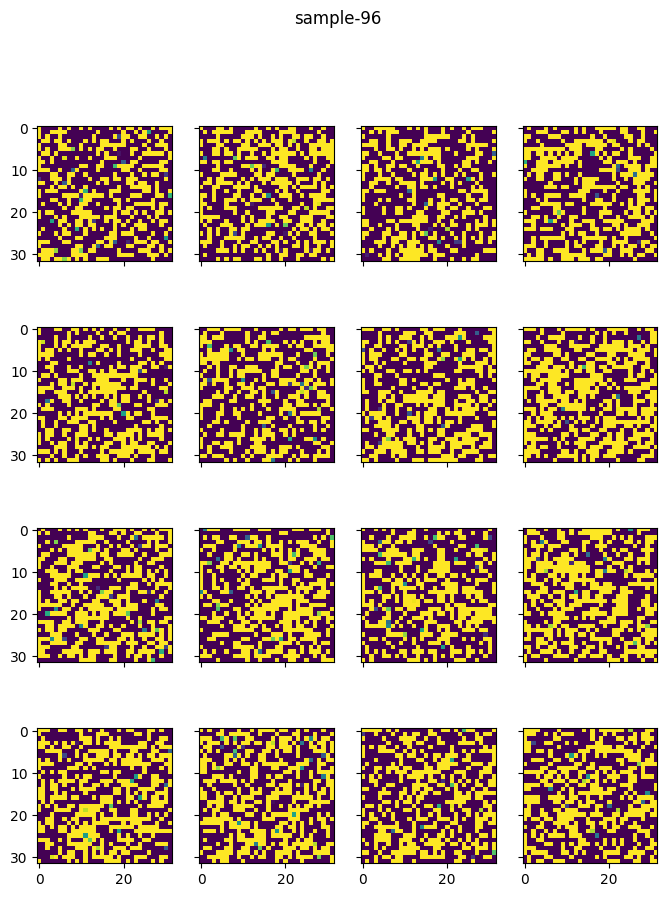

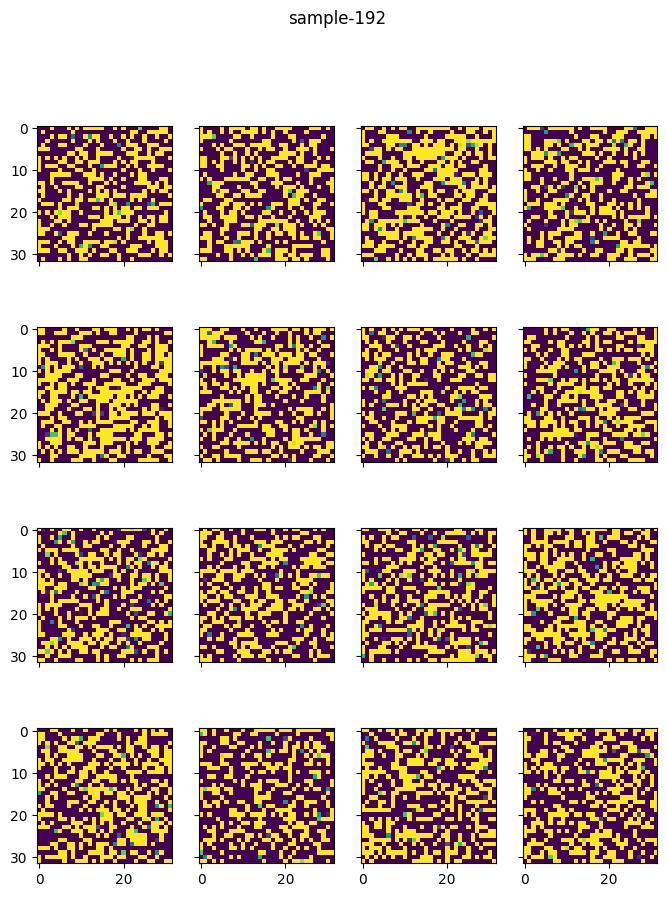

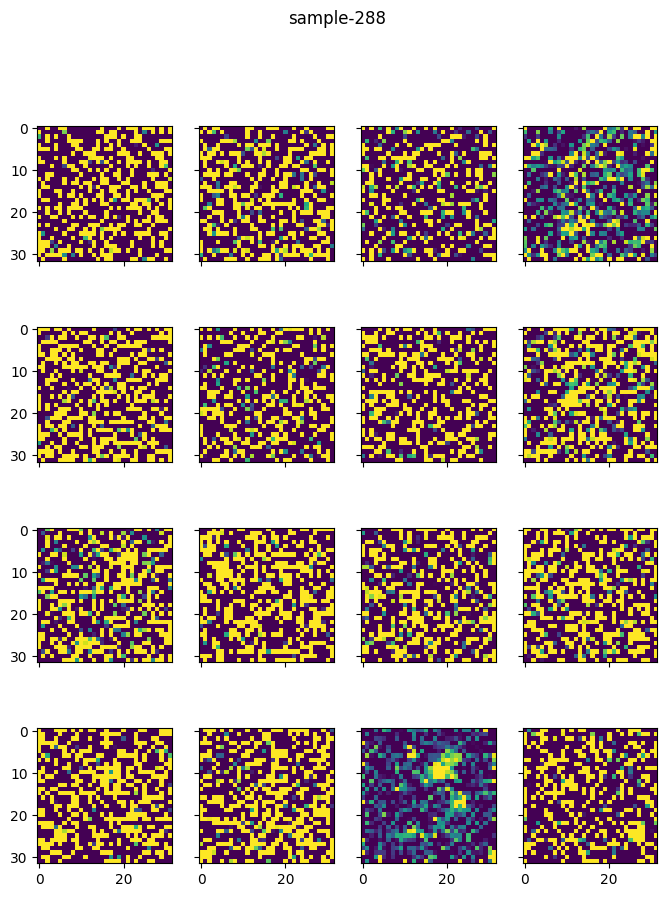

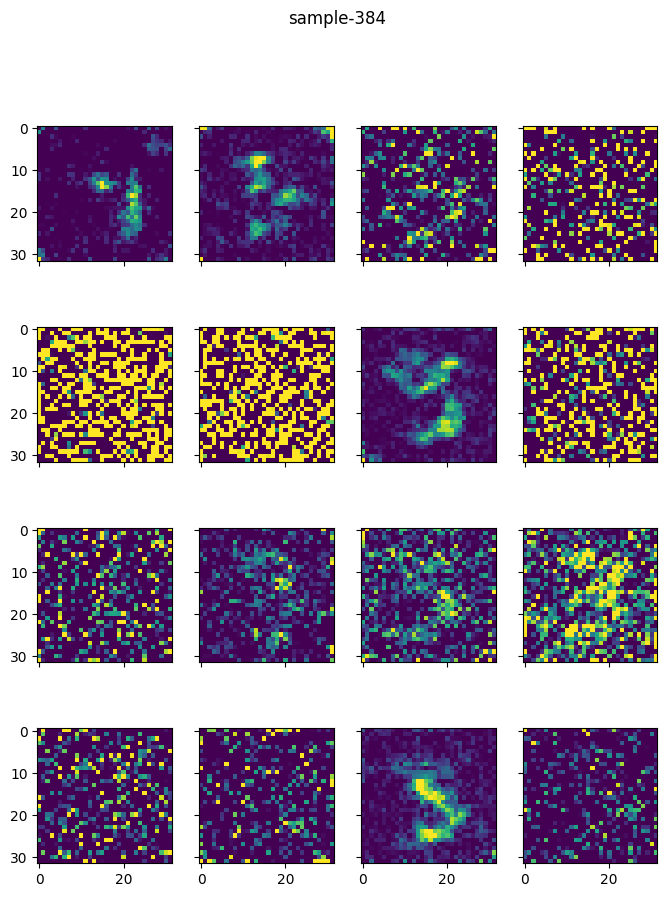

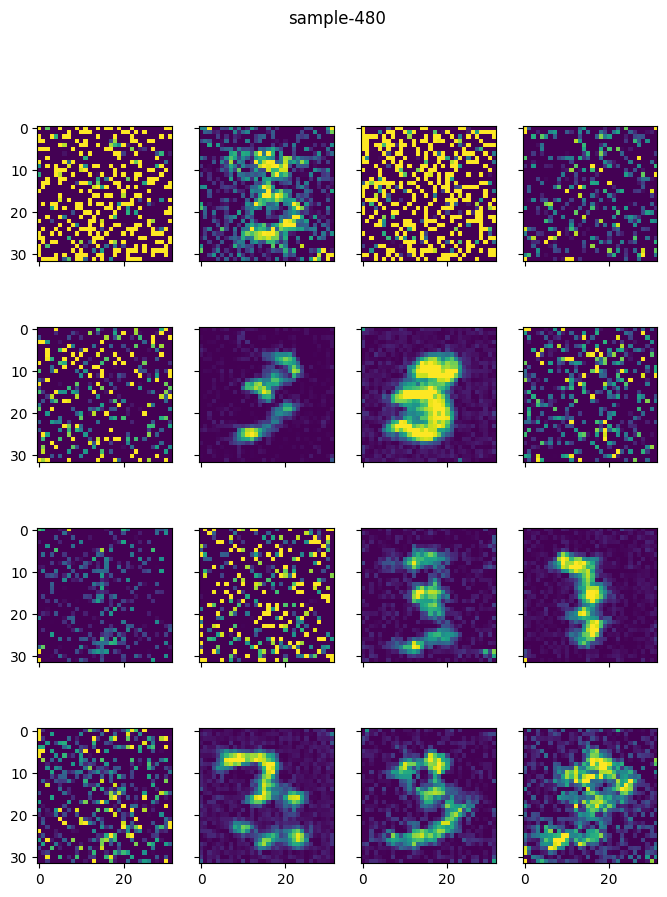

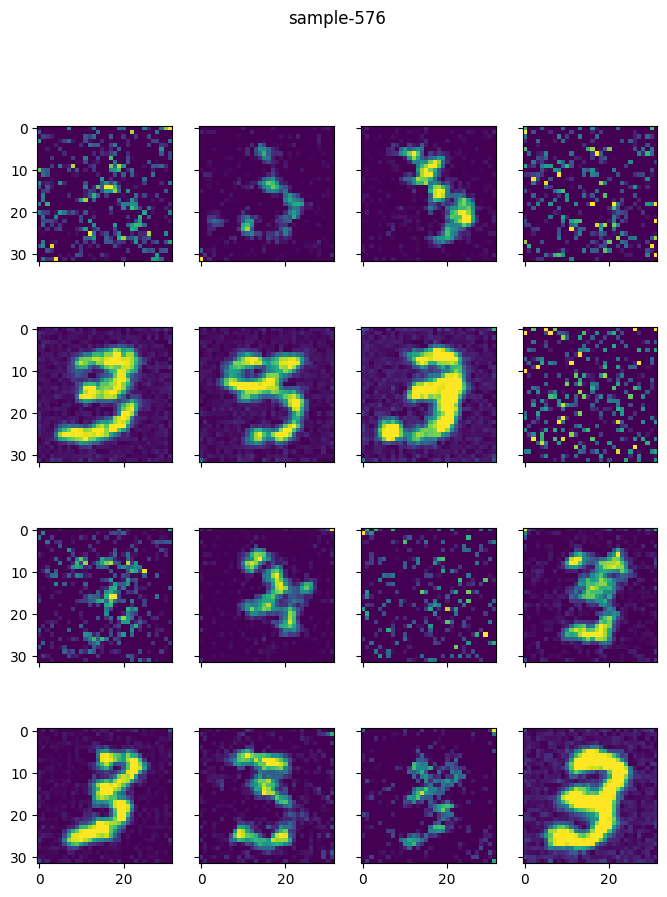

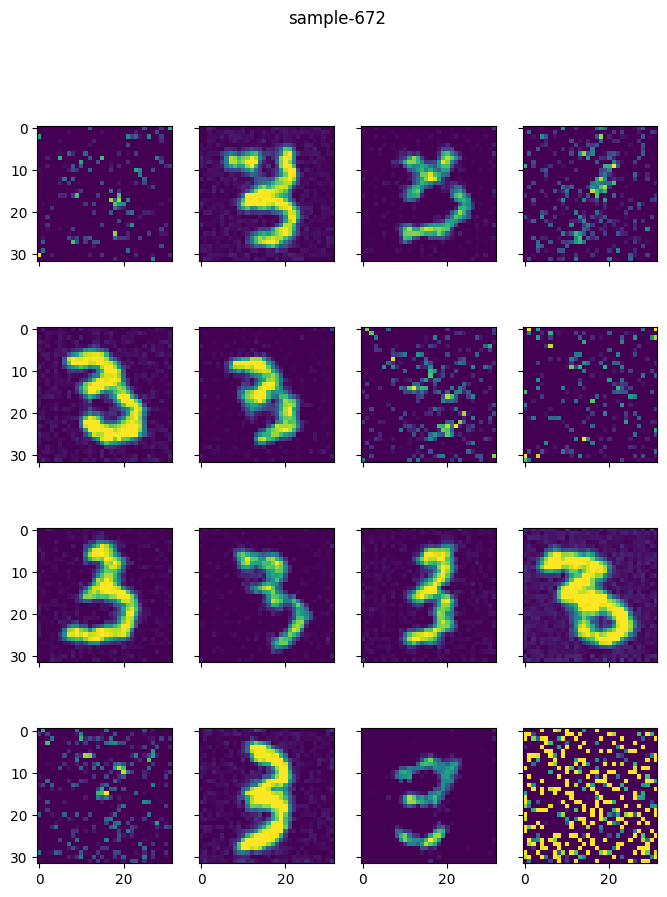

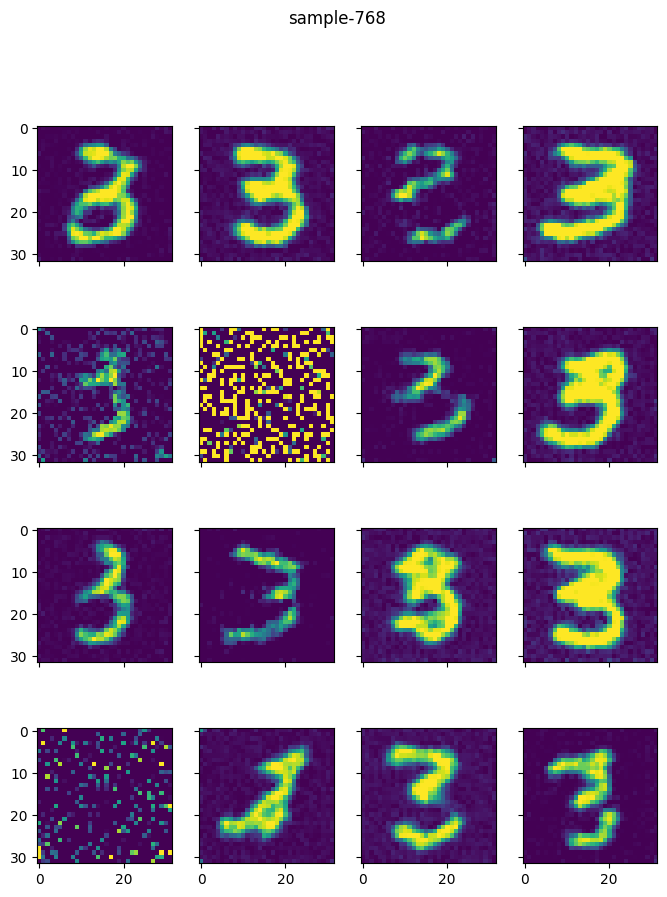

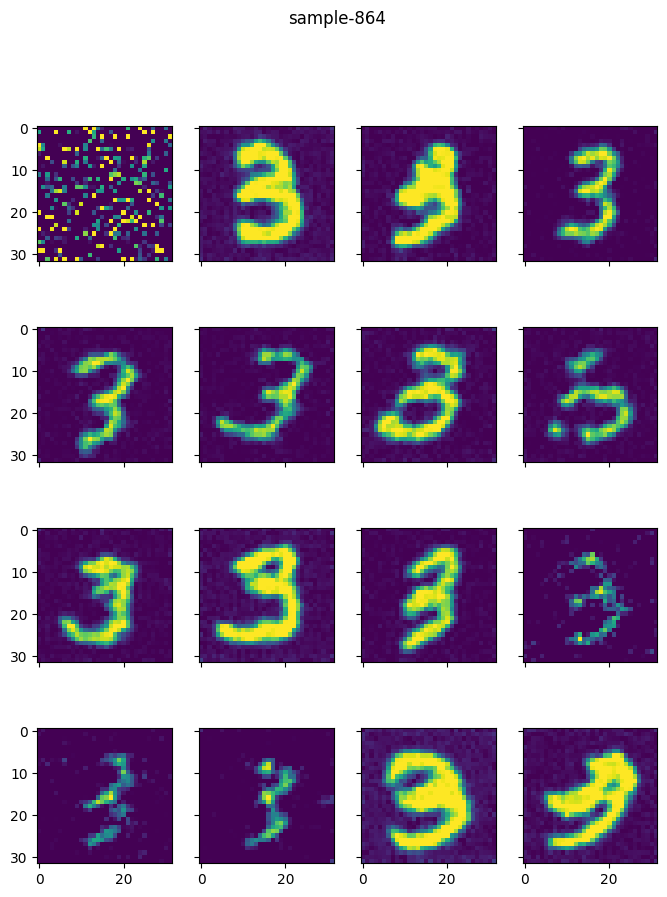

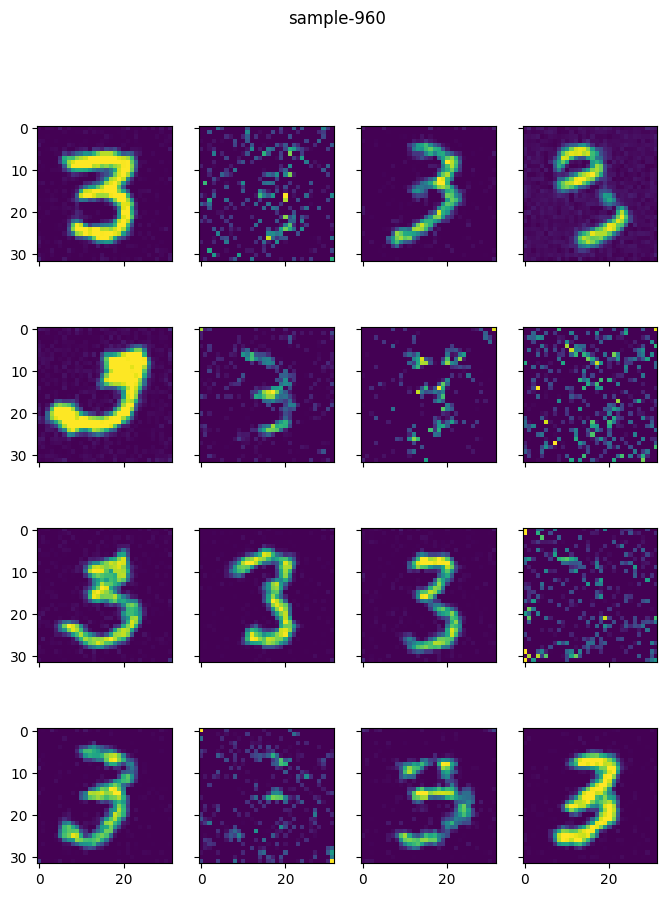

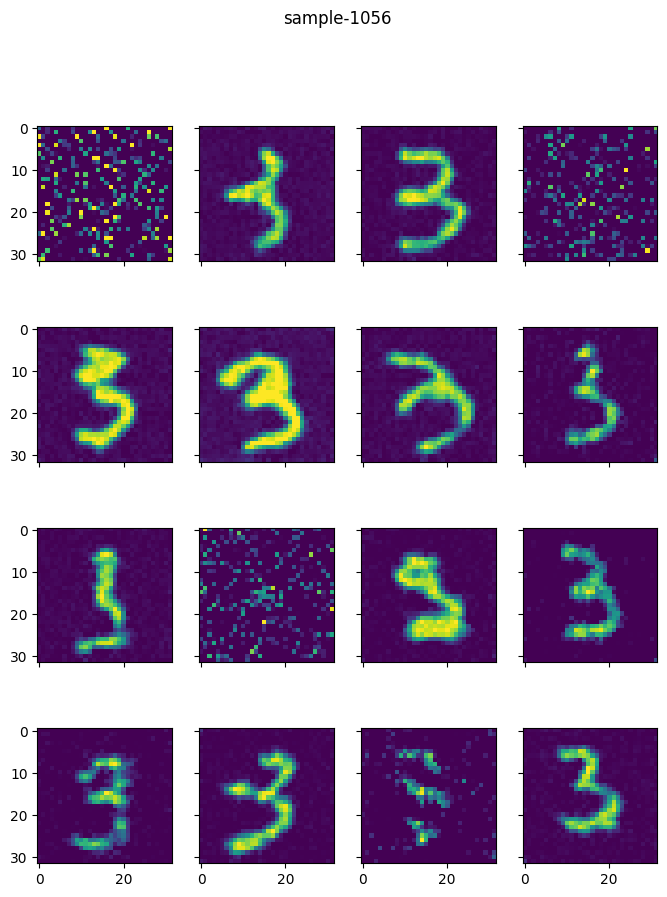

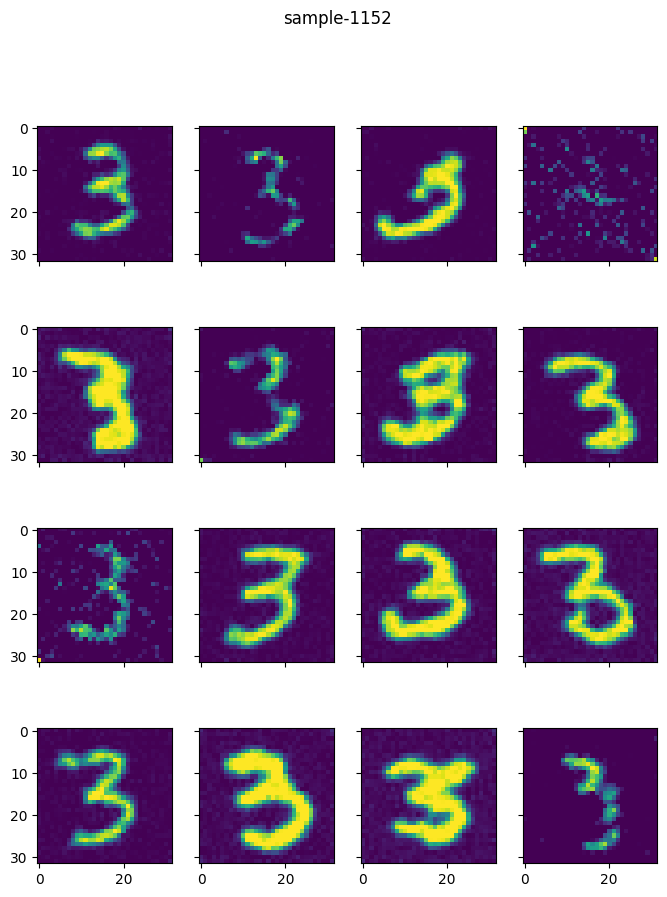

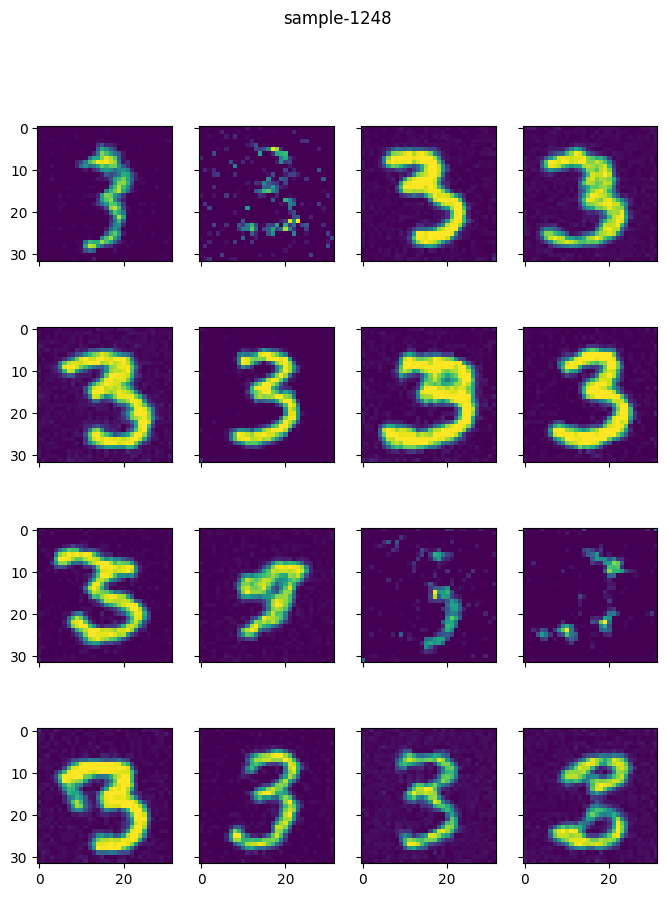

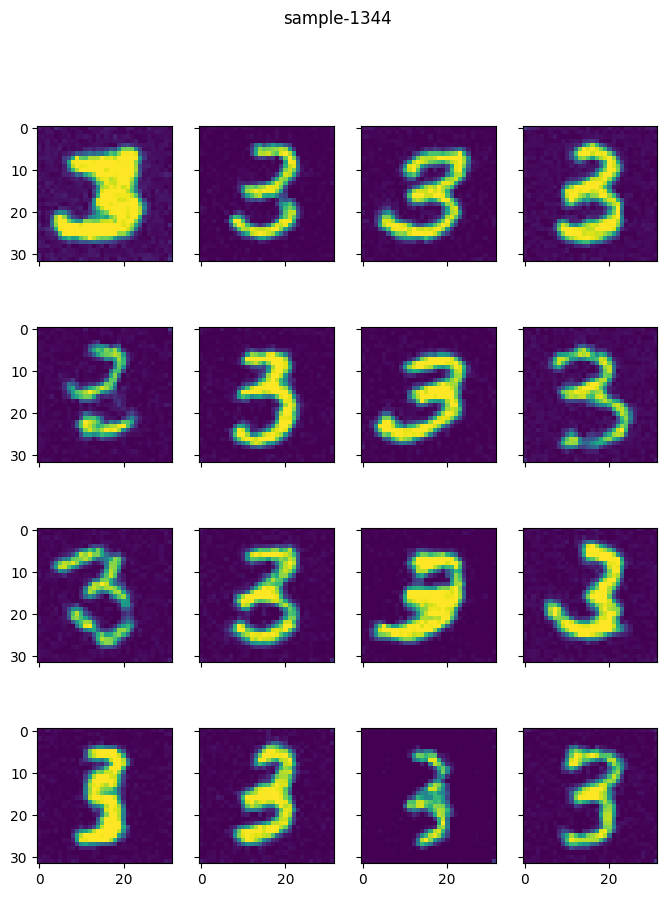

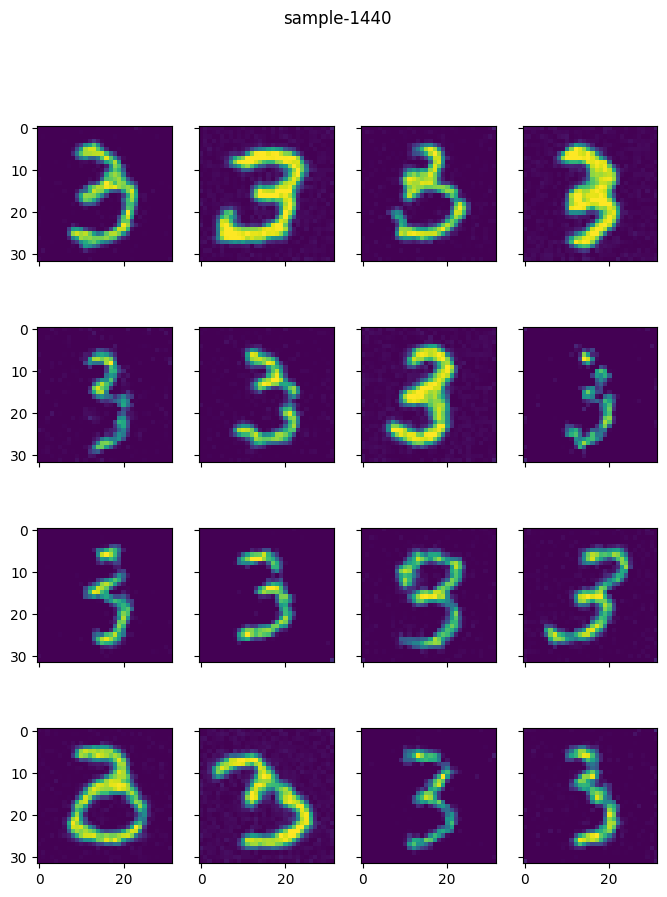

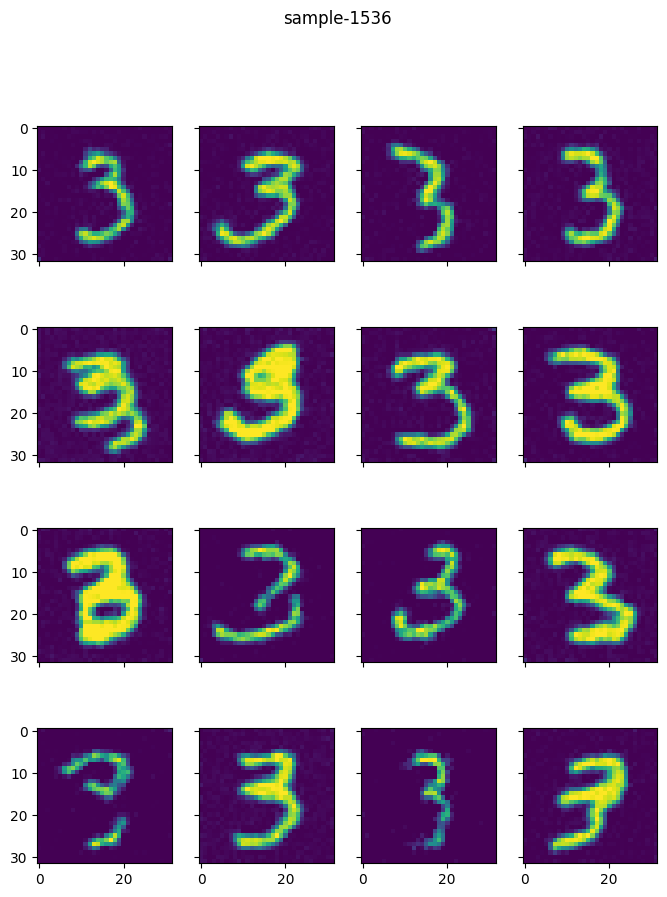

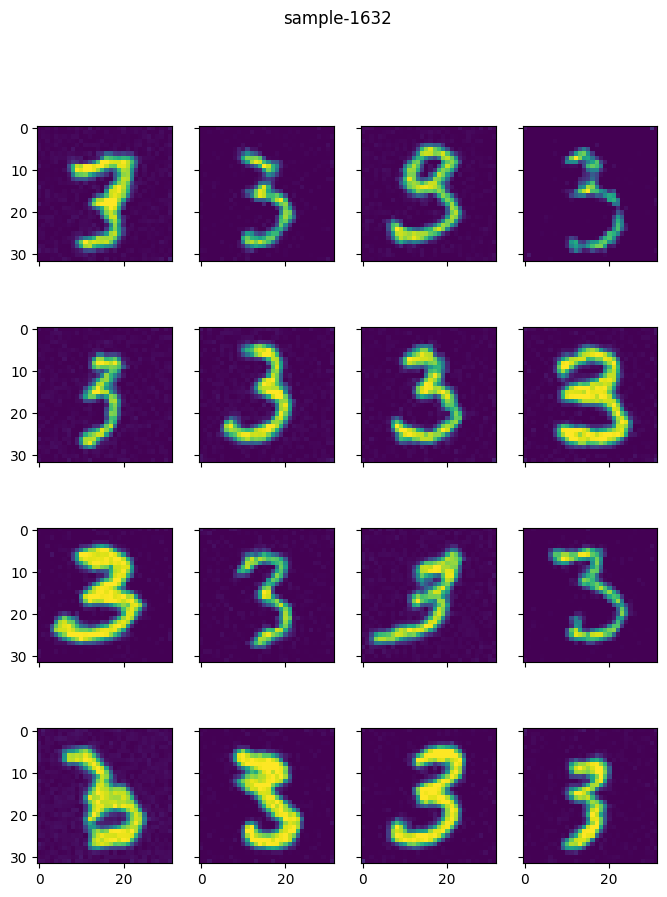

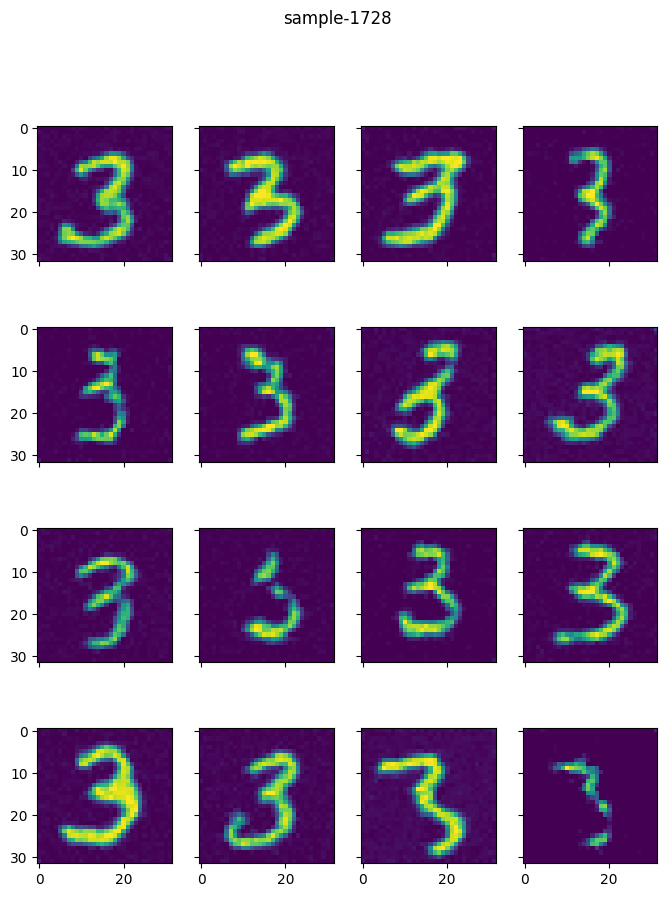

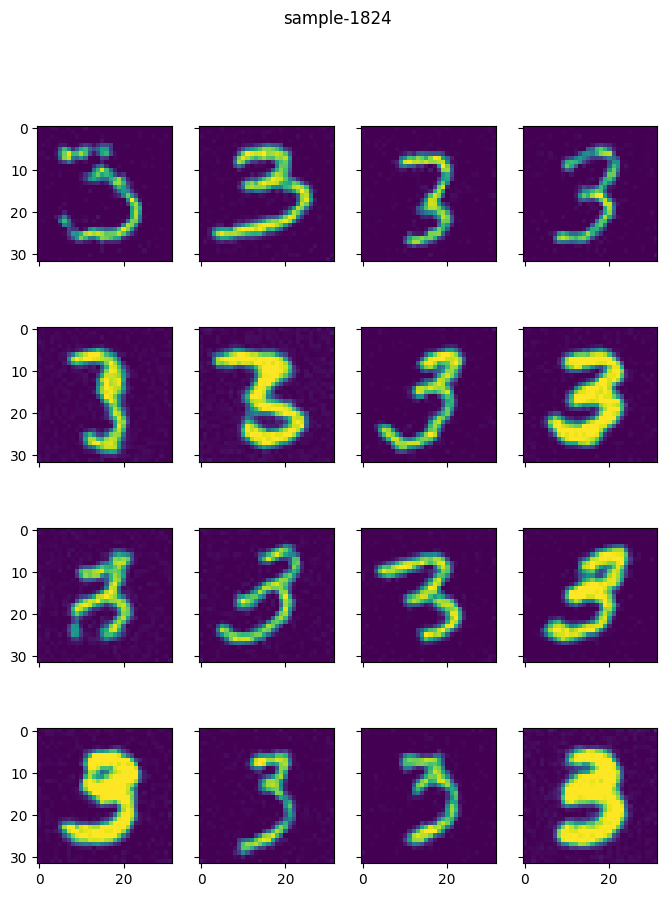

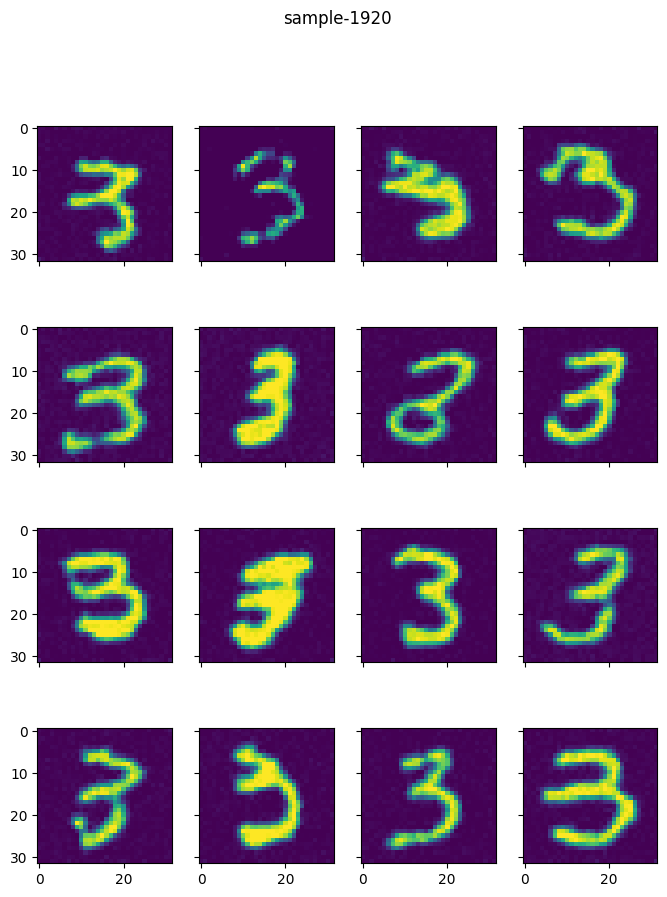

UUID 8ca39db6113911eebd560242ac1c000c


In [ ]:
if __name__ == '__main__':
    configs = Configs()
    experiment.create(name='diffuse', writers={'screen', 'labml'})
    train(configs, experiment)
    uuid = input("Insert the experiment ID: ")


In [ ]:
    eval(configs, uuid)